### Random Forest

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

def fit_transform_rf(X, y):
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=12345
    )

    rf = RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        class_weight="balanced",
        n_jobs=-1,
        random_state=12345
    )
    rf.fit(X_train, y_train)

    proba = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, proba)
    return rf, auc, proba

In [6]:
import pandas as pd

# 1) Cargar dataset ya preprocesado
df = pd.read_csv("application_train_1_3_2_Prework_.csv")

# 2) Separar ID, features y target
ids = df.get("SK_ID_CURR", pd.Series(range(len(df))))
X = df.drop(columns=["TARGET", "SK_ID_CURR"], errors="ignore")
y = df["TARGET"]

# 3) Entrenar/validar con tu helper
rf, auc, _ = fit_transform_rf(X, y)
print(f"ROC-AUC (validación): {auc:.6f}")

# 4) Re-entrenar en todo y predecir sobre TODO el dataset
rf.fit(X, y)
proba_full = rf.predict_proba(X)[:, 1]
pred_full = (proba_full >= 0.5).astype(int)

# 5) Exportar
out = pd.DataFrame({"SK_ID_CURR": ids, "TARGET_proba": proba_full, "TARGET_pred": pred_full})
out.to_csv("rf_pred_application_test_1_3_1_Prework_.csv", index=False)
print("Guardado: rf_pred_application_test_1_3_1_Prework_.csv")

ROC-AUC (validación): 0.747432
Guardado: rf_pred_application_test_1_3_1_Prework_.csv


Una vez corrido el randomforest, hacemos una visualización de la importancia predictiva de cada variable

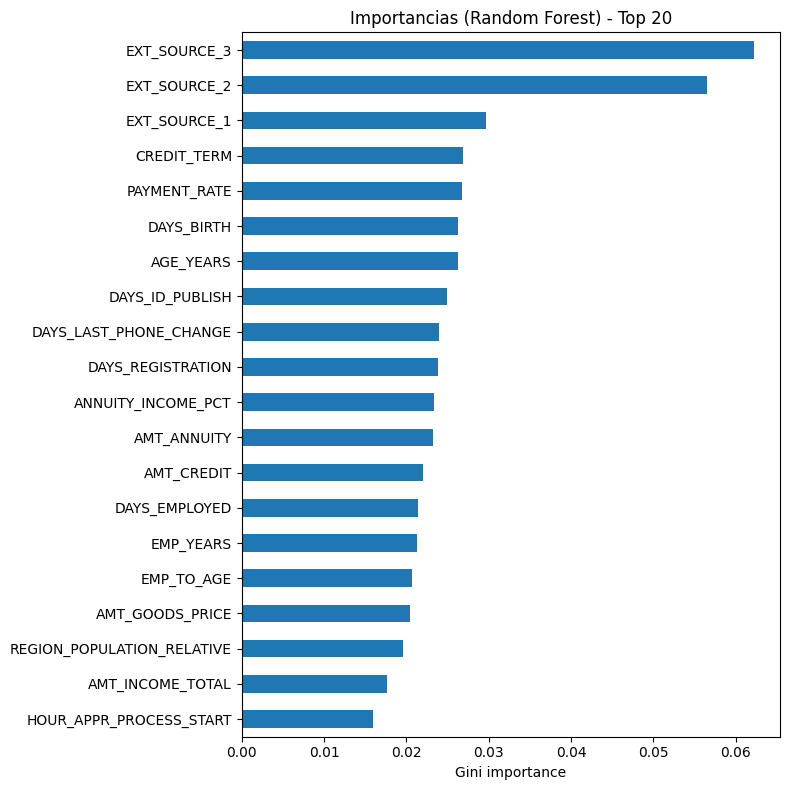

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

#Importancias y gráfico (Top 20)
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
top_k = 20
top = imp.head(top_k)[::-1]  # invertir para barh ascendente

plt.figure(figsize=(8, max(4, top_k*0.4)))
top.plot(kind="barh")
plt.title("Importancias (Random Forest) - Top 20")
plt.xlabel("Gini importance")
plt.tight_layout()
plt.show()


La idea es eliminar las columnas con poco poer predictivo, de esta forma hacemos el modelo más ágil.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

THRESH = 0.01  # umbral de importancia

# 1) Entrenar un RF base para obtener importancias
rf_base = RandomForestClassifier(
    n_estimators=400, class_weight="balanced",
    n_jobs=-1, random_state=12345
)
rf_base.fit(X, y)

imp = pd.Series(rf_base.feature_importances_, index=X.columns).sort_values(ascending=False)

# 2) Listar variables con poca importancia
low_imp_cols = imp[imp < THRESH].index.tolist()
print(f"Variables con importancia < {THRESH:.2f}: {len(low_imp_cols)}")
# Si querés verlas:
# print(low_imp_cols)

# 3) Armar dataset reducido y fallback si ninguna supera el umbral
keep_cols = imp[imp >= THRESH].index.tolist()
if len(keep_cols) == 0:
    keep_cols = imp.head(20).index.tolist()
    print("⚠️ Ninguna variable ≥ umbral. Se conservan las Top 20 por importancia.")

X_red = X[keep_cols]

# 4) Nueva predicción con las features seleccionadas
X_tr, X_va, y_tr, y_va = train_test_split(X_red, y, test_size=0.2, stratify=y, random_state=12345)

rf_new = RandomForestClassifier(
    n_estimators=400, class_weight="balanced",
    n_jobs=-1, random_state=12345
)
rf_new.fit(X_tr, y_tr)

proba = rf_new.predict_proba(X_va)[:, 1]
pred  = (proba >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_va, proba))
print("Accuracy:", accuracy_score(y_va, pred))
print("F1:", f1_score(y_va, pred))

Variables con importancia < 0.01: 244
